# Homework 4 - Applied ML

In [1]:
# General
import numpy as np
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# seaborn
import seaborn as sns

# scikit learn (other import in utils.py)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# display progress bar
from ipywidgets import FloatProgress
from IPython.display import display

import itertools

# our code (mark it at autoreload at every cell execution - useful in developement mode)
%load_ext autoreload
%autoreload 1
%aimport utils

**IMPORTANT NOTE:** For readability reasons, we decide to store all defined functions in a file called *utils.py*.

When functions are used in a cell, a comment mentions it (*# UTILS: use of &lt;name of function 1&gt;[, &lt;name of function 2&gt;, ...]*).

## 0 - Cleaning data

In this part, we review obtained data and clean them before doing any manipulation with (un)supervised classifiers.

In [2]:
soccer_data = pd.read_csv('CrowdstormingDataJuly1st.csv', sep=',', parse_dates=['birthday'])
soccer_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,1992-12-17,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,1993-08-31,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,1991-07-18,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


Note: It is really important to understand data before using ML techniques, to avoid misunderstanding of results and errors during manipulation. A detailed description of each columns is provided in the file `DATA.md`. We invite the reader to take note of these descriptions before continuing.

### Compute of age

A first modification that we propose to do is to compute the age of players according to the given birthday date. Thus, we'll use this feature if needed instead of the birthday's column (which is quite understandable as we use a RandomForest where each decision tree will split data according to the values). To keep the model usable with other new data, we prefere to compute the age based on the moment when data have been collected.

In [3]:
# UTILS: use of compute_age
soccer_data['age'] = soccer_data.apply(utils.compute_age, axis=1)
soccer_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,age
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,29
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,30
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,1992-12-17,181.0,79.0,NaN,1,0,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,20
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,1993-08-31,191.0,87.0,Center Back,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,19
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,1991-07-18,172.0,70.0,Right Midfielder,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,21


### Merge raters' values

Here, as we want to determine the skin color of a player according to the given data, it is important that at least one rater has given a note.

In [4]:
soccer_data['rater1'].value_counts(dropna=False)

 0.00    49774
 0.25    43708
NaN      21407
 0.50    13518
 0.75     9501
 1.00     8120
Name: rater1, dtype: int64

In [5]:
soccer_data['rater2'].value_counts(dropna=False)

 0.25    56483
 0.00    35712
NaN      21407
 0.50    12650
 0.75     9915
 1.00     9861
Name: rater2, dtype: int64

As we can see, there are some players for whom there is no rater 1 or rater 2 (in particular, here, it seems that when there is no rater 1, there is no rater 2).

We decide to remove all dyads for which we don't have any rate.

Note: We could have chosen to drop all rows where there is no photo ID, but it is better to consider directly raters instead, as in theory (!) nothing prevents having a photo ID of a player but no raters.

In [6]:
soccer_data_clean = soccer_data[soccer_data['rater1'].notnull() | soccer_data['rater2'].notnull()].copy()

Now, we decide to combine these data to have an unique rate.

Here, we suppose that raters' votes are independent (no influence on votes between the two raters) and that raters were honest, for lack of exactitude. Thus, we use the mean to compute the global rate.

We also transform the computed rate in integer as it will be easier to deal with this kind of type using RandomForest, for example.

In [7]:
soccer_data_clean['rater'] = np.floor(soccer_data_clean[['rater1', 'rater2']].mean(axis=1) * 100)

Finally, we can plot the distribution of rates to have an idea of players we are considering here.

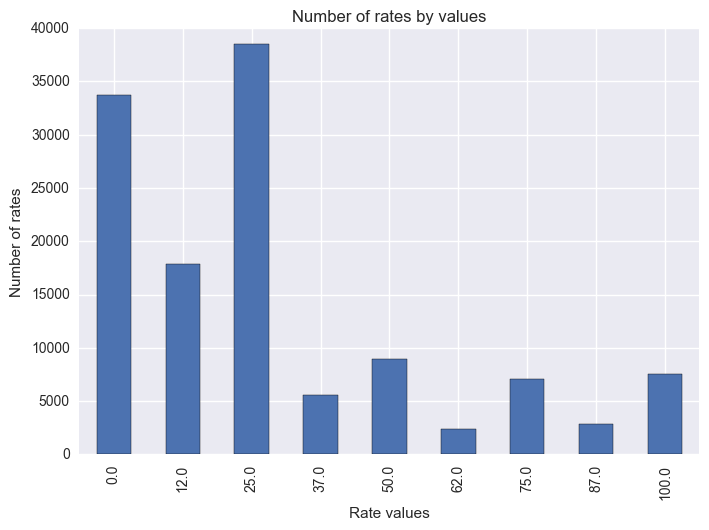

In [8]:
rater_distinct_values = soccer_data_clean['rater'].value_counts(dropna=False, sort=False).plot(kind='bar')
rater_distinct_values.set_ylabel('Number of rates')
rater_distinct_values.set_xlabel('Rate values')
rater_distinct_values.set_title('Number of rates by values')

Among other things, we see that a majority of players stored in data were described as having (very) light skin.

### Manage null values

Now, let's check if there is any null value in the data.

In [9]:
count_null_values = soccer_data_clean.isnull().sum()
count_null_values[[value > 0 for value in count_null_values.values]]

height        46
weight       753
position    8461
Alpha_3        1
meanIAT      153
nIAT         153
seIAT        153
meanExp      153
nExp         153
seExp        153
dtype: int64

For height and weight, we decide to use mean of values to replace null values.

In [10]:
soccer_data_clean[['height', 'weight']] = soccer_data_clean[['height', 'weight']].fillna(soccer_data_clean[['height', 'weight']].mean())

There also seems to be a non-negligible number of null values for position. We decide to fill these null values with an explicit string (*Unknown*) to avoid any future problem when passing data to our classifiers.

In [11]:
soccer_data_clean['position'] = soccer_data_clean['position'].fillna('Unknown')

Now, as IAT and Explicit bias scores will be very important for manipulations we plan to do in next parts, we decide to drop any dyad for which these values are missing.

Regarding the *Alpa_3* column, we also decide to remove rows having null value. This will not have any impact at all (only one row is affected, while, in the same time, we manipulate a set of 100000+ rows).

In [12]:
soccer_data_clean = soccer_data_clean.dropna(axis=0, how='any', subset=['Alpha_3', 'meanIAT', 'meanExp'])

We ensure that there are no more null values at this stage.

In [13]:
count_null_values = soccer_data_clean.isnull().sum()
print('Assumption to be tested: there is remaining null values in DataFrame')
print('Result: ' + str(len(count_null_values[[value > 0 for value in count_null_values.values]]) > 0))

Assumption to be tested: there is remaining null values in DataFrame
Result: False


## 1 - Processing data for machine learning

### Manage the dimension of dyads

*Guideline: We only want to have data related to players and not dyads at the end of this part. Thus, we will merge important information related to referees with players' data when needed, and throw unrelevant features.*

First, let's describe all data related to IAT and Explicit bias scores.

In [14]:
soccer_data_clean[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']].describe()

,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,124468.000000,1.244680e+05,1.244680e+05,124468.000000,1.244680e+05,124468.000000
mean,0.348123,1.817187e+04,6.287461e-04,0.463797,1.884147e+04,0.002988
std,0.032087,1.261437e+05,4.788647e-03,0.219206,1.296022e+05,0.019719
min,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,0.334684,1.785000e+03,5.454025e-05,0.336101,1.897000e+03,0.000225
50%,0.336628,2.882000e+03,1.508847e-04,0.356446,3.011000e+03,0.000586
75%,0.369894,7.749000e+03,2.294896e-04,0.588297,7.974000e+03,0.001002
max,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


As we can see, the min of nExp and nIAT is equal to two. Thus, we'll deduce nothing relevant as these values are not representative of the entire population.

More generelly, we need to take the sample's size into account when we will apply ponderation.

In [15]:
# Higher is the standard error, the lesser we can trust the result of the tests.
# We reverse the value in order to take into account only values which have a low standard error.
reverse_seIAT = abs(soccer_data_clean['seIAT'] - max(soccer_data_clean['seIAT']))
reverse_seExp = abs(soccer_data_clean['seExp'] - max(soccer_data_clean['seExp']))

# In order to not penalize one study compared to another, we need to use the same maximum.
soccer_data_clean['reverse_seIAT'] = reverse_seIAT / max(reverse_seIAT)
soccer_data_clean['reverse_seExp'] = reverse_seExp / max(reverse_seExp)

# We then compute the score of ponderation, taking into account the standard error and the values of different tests.
soccer_data_clean['associationScore'] = (soccer_data_clean['meanIAT']*soccer_data_clean['reverse_seIAT']  +
                                         soccer_data_clean['meanExp']*soccer_data_clean['reverse_seExp']) / (2)


# We can plot the result to show that there are not too much values equal to 0.
# Understanding of graphs:
# The lower is the value (i.e. the higher is the curve for a given row), the lesser we can trust the result of the tests and the lower the impact of the applied ponderation will be.
# Abscissa: n° of row
# Ordinate: Ponderation (score)
#soccer_data_clean['reverse_seIAT'].plot(legend=True)
#soccer_data_clean['reverse_seExp'].plot(legend=True)

Now, for each type of cards, we will apply a regulation (ponderation) according to the IAT and Explicit scores (which were adjusted in previous step).

Indeed, we can't deny that racism exists in sport, and probably even more in football (see for example the newspapers or the campaigns of FIFA and UEFA to eliminate racism). Among other forms of racism, we have the fact that a referee can penalize a player by giving him a yellow/red/yellow+red card even if it is not justified.

Now, the question is more about how to regulate results stored in DataFrame. As we want to highlight racism in the decision of referee, we increase the gap between White players and Black players when there is *negative* discrimination.

By *negative* discrimination, we consider the two following cases:

1. Referee's country has a positive score (IAT or Explicit bias) and player is black (rate from 0.5 to 1).
2. Referee's country has a negative score (IAT or Explicit bias) and player is white (rate from 0 to 0.5).

So, in case n°1, we will increase the number of received cards while in the second case we will decrease the number of received cards. It is important to understand that by doing this, we are not saying that a White player who received a card by a referee with negative IAT and Explicit score (i.e. *preference* for Black people and *dislike* of White people) must have received less cards ; we only increase the gap between White players and Black players, as said before. Notice that we could have done the contrary (reversal of cases 1 and 2).

(For implementation, check *utils.py* file.)

In [16]:
# UTILS: use of regulate_number_of_cards
for column_name in ['yellowCards', 'yellowReds', 'redCards']:
    soccer_data_clean['regulated' + column_name[0].upper() + column_name[1:]] = soccer_data_clean.apply(func=utils.regulate_number_of_cards, args=(column_name,), axis=1)

In order to see an extract of the regulation result, we select some players with cards:

In [17]:
index = [(y > 0 and yr > 0 and r > 0) for y, yr, r in soccer_data_clean[['yellowCards', 'yellowReds', 'redCards']].values]
soccer_data_clean[['playerShort', 'rater', 'yellowCards', 'regulatedYellowCards', 'yellowReds', 'regulatedYellowReds', 'redCards', 'regulatedRedCards']][index].head()

,playerShort,rater,yellowCards,regulatedYellowCards,yellowReds,regulatedYellowReds,redCards,regulatedRedCards
2486,dani-alves,37.0,5,5.885539,1,1.177108,1,1.177108
3018,sergio-ramos,0.0,14,14.000000,2,2.000000,1,1.000000
3183,arribas_2,25.0,1,1.119667,1,1.119667,1,1.119667
5718,medhi-lacen,25.0,3,3.359002,1,1.119667,1,1.119667
8337,lee-cattermole,12.0,2,2.081973,1,1.040987,1,1.040987


We can plot the number of received cards before and after regulation, to see the effect.

*How to interpret graphs:<br/>For a given number of cards x, we obtain all the values y after regulation on ordinate axis.<br/>For example, let's consider yellow cards. When players received 2 cards, then after ponderation, the number of received card varies from 1.5 to 4, which correspond, to a White player and a Black player, respectively (cf. explanation above for ponderation used here).*

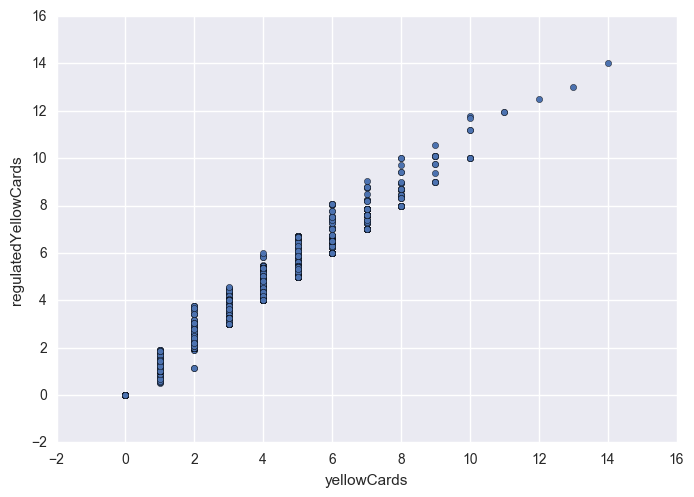

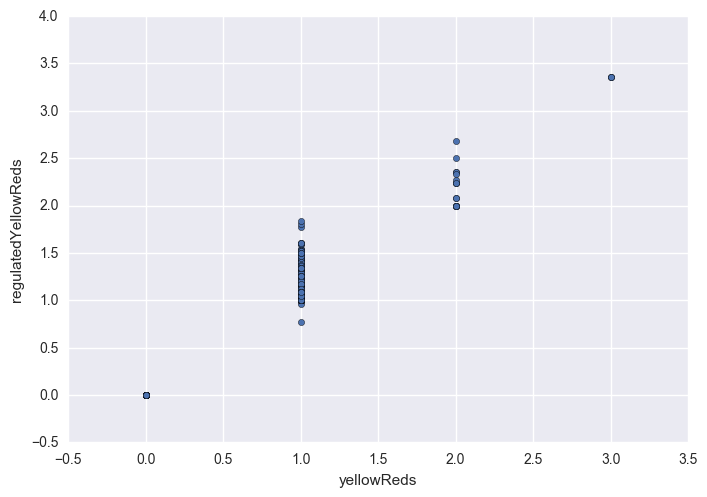

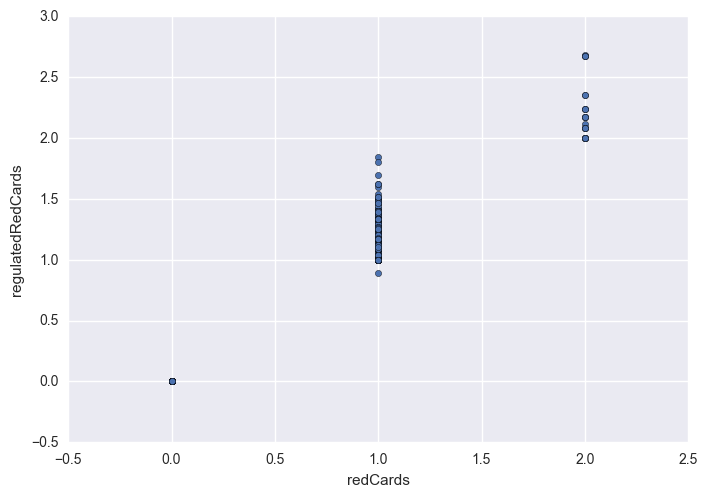

In [18]:
soccer_data_clean.plot.scatter(x='yellowCards', y='regulatedYellowCards');
soccer_data_clean.plot.scatter(x='yellowReds', y='regulatedYellowReds');
soccer_data_clean.plot.scatter(x='redCards', y='regulatedRedCards');

### Aggregating by players

Now, we sum all the statistics of a player as we want to have one row for each player, at the end.

In [19]:
global_statistics = soccer_data_clean[['playerShort', 'games', 'victories', 'defeats', 'goals', 'regulatedYellowCards', 'regulatedYellowReds', 'regulatedRedCards']].groupby('playerShort').sum()
global_statistics.head()

,games,victories,defeats,goals,regulatedYellowCards,regulatedYellowReds,regulatedRedCards
playerShort,,,,,,,
aaron-hughes,654,247,228,9,19.878562,0.000000,0.000000
aaron-hunt,336,141,122,62,43.837501,0.000000,1.040348
aaron-lennon,412,200,115,31,12.008961,0.000000,0.000000
aaron-ramsey,260,150,68,39,31.000000,0.000000,1.000000
abdelhamid-el-kaoutari,124,41,43,1,8.670423,4.351209,2.167606


Finally, we create our final DataFrame containing information about a player and some statistics of his career.

Here, we assume that the identity (age, height, weight, skin color) of a player is the same, so we use first row/first apparition in DataFrame as reference.

We also create a binary column for each position, club and league country because it will be easier to use these features in ML's part, but also because it ensures that we don't loose information about the career of a player during the process.

In [20]:
players = soccer_data_clean.groupby('playerShort').first()

# DataFrame containing all features
soccer_data_all_features = global_statistics.join(players[['age', 'height', 'weight', 'rater']]).copy()

# Creation of new columns for these features
for feature in ['club', 'leagueCountry', 'position']:
    soccer_data_all_features = soccer_data_all_features.merge(pd.get_dummies(players[feature]), left_index=True, right_index=True)
    
soccer_data_all_features.head()

,games,victories,defeats,goals,regulatedYellowCards,regulatedYellowReds,regulatedRedCards,age,height,weight,...,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger,Unknown
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,654,247,228,9,19.878562,0.000000,0.000000,33,182.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,336,141,122,62,43.837501,0.000000,1.040348,26,183.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,412,200,115,31,12.008961,0.000000,0.000000,25,165.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
aaron-ramsey,260,150,68,39,31.000000,0.000000,1.000000,22,178.0,76.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,124,41,43,1,8.670423,4.351209,2.167606,22,180.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Categorize the color skin

We decide here to categorize the skin color, and more precisely to define two different categories: light skin (white) and dark skin (black).

In [21]:
classes_column = 'raterBinarized'
soccer_data_all_features[classes_column] = pd.cut(soccer_data_all_features['rater'], [0, 51, 101], labels=['light skin', 'dark skin'], right=False)

Notice that we could have created more categories, as the ones available for raters. However, doing this will add more difficulty to create a very performant model, which is not the priority at this stage (plus it is sufficient to only consider two categories here as we are dealing with skin color and as we only want to have a global overview).

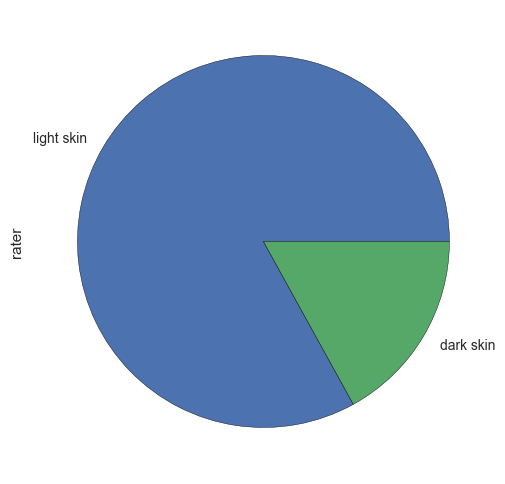

In [22]:
colorSkin = pd.cut(soccer_data_all_features['rater'], [0, 51, 101], labels=['light skin', 'dark skin'], right=False)
colorSkin.value_counts().plot(kind='pie', figsize=(6, 6))

At the end of this part, original DataFrame was substantially modified. We draw reader's attention on the fact that either we created new features which includes data from previous features (it's the case for the regulation of cards, which uses IAT and Explicit bias scores for example) or we dropped features which are not useful for what we plan to do (like the photoID or the refNum), so we can safely continue our analysis.

## 2 - Question 1 : from player description to skin color

**Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?**

### Selection of features

We first group all available features, excluding the classes (*rater* and *raterBinarized* columns).

In [23]:
classes_column = 'raterBinarized'
all_features = [col for col in soccer_data_all_features.columns if col not in ['rater', classes_column]]

### RandomForest without cross validation

We create a RandomForest with default parameters.

In [24]:
# UTILS: use of get_random_forests (generate a set of random forests estimators with different parameters,
# Note that by default only one RF is returned with default parameters from scikit learn)
cfs = utils.get_random_forests()

Then we fit/predict with our data.

In [25]:
# UTILS: use of run_once (this split, fit and score the model with given estimators)
# We provide only one estimator, so we have only one result at this stage
results_single = utils.run_once(cfs, soccer_data_all_features, all_features, classes_column)

Let's display accuracy and F-score.

In [26]:
print('Accuracy: ' + str(results_single[0]['scores']['accuracy']))
print('F-score: ' + str(results_single[0]['scores']['f-score']))

Accuracy: 0.856423173804
F-score: 0.91914893617


As we can see, we obtain quite good results here. Our classifier is accurate and there is no major issue regarding precision and recall's scores, as F-score is high.

Now let's display the ROC curve.

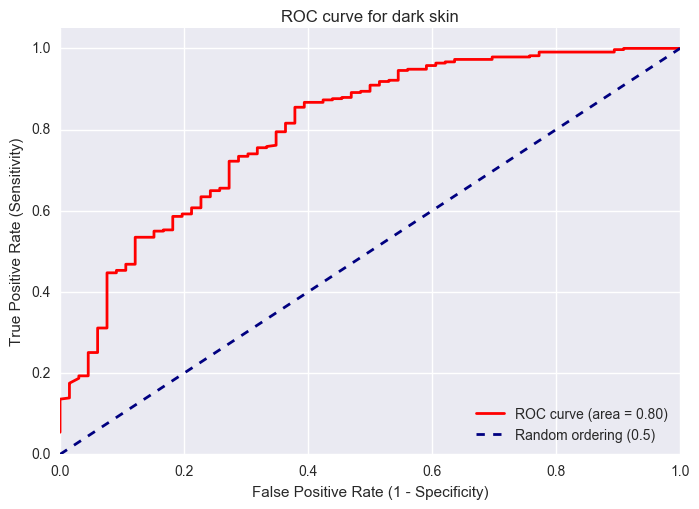

In [27]:
# We retrieve FPR and TPR
false_positive_rate = results_single[0]['scores']['roc'][0]
true_positive_rate = results_single[0]['scores']['roc'][1]

# Code adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='red', lw=lw, label='ROC curve (area = %0.2f)' % results_single[0]['scores']['roc_auc'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random ordering (0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve for dark skin')
plt.legend(loc="lower right")
plt.show()

We remind that when AUC (Area Under Curve) is equal to 0.5 (see blue, dotted curve), our classifier does a random ordering. Here, we reach a higher AUC which is quite good again (the objective is to have a AUC very high, ideally which is equal to 1).

Finally, we can plot a confusion matrix to have an idea of how our classifier behaves when we give to it a set that he has never seen before.

Confusion matrix, without normalization
[[ 16  50]
 [  7 324]]


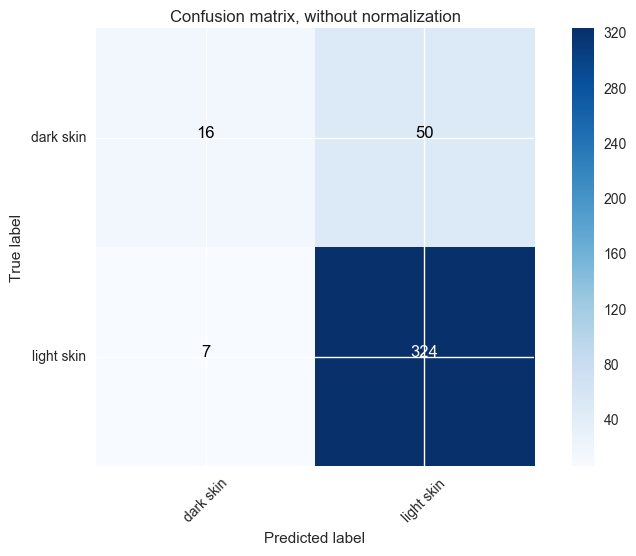

In [28]:
# UTILS: use of plot_confusion_matrix
plt.figure()
utils.plot_confusion_matrix(results_single[0]['confusion_matrix'], classes=['dark skin', 'light skin'], title='Confusion matrix, without normalization')
plt.show()

As seen before, we have a high number of players' rows which refer to White players.

### RandomForest and Cross-validation

Now, we want to run cross validation to see how our classifiers behave in more realistic conditions. Note that we run K-fold cross validation with K=10 here.

In [29]:
# UTILS: use of get_random_forests, run_cross_validation
cfs = utils.get_random_forests(nb_trees=[10, 100], min_leaf=[2], min_split=[2])
results_cv = utils.run_cross_validation(cfs, soccer_data_all_features, all_features, classes_column)

Let's display accuracy and F-score (mean between 10-fold cross validation), as previously.

In [30]:
for i in range(0, len(results_cv)):
    print('Number of trees in RandomForest: ' + str(results_cv[i]['classifier'].n_estimators))
    print('Accuracy: ' + str(results_cv[i]['scores']['accuracy_mean']))
    print('F-score: ' + str(results_cv[i]['scores']['f1_mean']))
    print('\n')

Number of trees in RandomForest: 10
Accuracy: 0.86248997884
F-score: 0.641511371453


Number of trees in RandomForest: 100
Accuracy: 0.866247590738
F-score: 0.629708600308




If accuracy is still the same, approximately, as before, we see that is not the case of F-score anymore. This means that our classifier does more mistakes and that in the first run, we had overfitting!

### Features importance

What we want to do now is to check how our RandomForest classifier (let's say the first one used) used the features we gave to it to create the different trees and, finally, to determine the correct skin color of players from test set.

Here, we assume a threeshold of 7% relative to the most important feature used (by default, threshold was defined to 10).

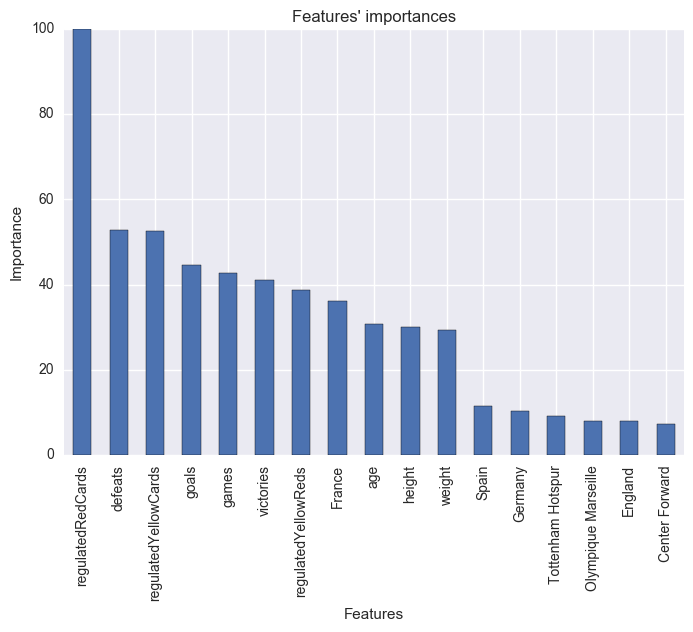

In [31]:
# UTILS: use of retrieve_above_threshold
features_importance = utils.retrieve_above_threshold(results_single[0]['classifier'], all_features, 7).sort_values(ascending=False)

features_importance_plot = features_importance.plot(kind='bar')
features_importance_plot.set_ylabel('Importance')
features_importance_plot.set_xlabel('Features')
features_importance_plot.set_title('Features\' importances')

Let's take a look of the proportion of relevant features, then.

In [32]:
all_features_len = len(all_features)
features_importance_len = len(features_importance)
print('Number of features: ' + str(all_features_len))
print('Number of relevant features (importance score above threshold=7%): ' + str(features_importance_len))
print('Ratio: ' + str(features_importance_len / all_features_len))

Number of features: 124
Number of relevant features (importance score above threshold=7%): 17
Ratio: 0.13709677419354838


As we can see, only 14% of features are really important for our classifier. All other ones seem to be not useful.

### Try with important features only

A legitimate question, now, is: excluding these features which are not important, will the classifier be more able to determine correctly the skin color of players (higher score)?

Let's see it!

In [33]:
# We only keep important features in our DataFrame
soccer_data_selected_features = soccer_data_all_features[np.concatenate((features_importance.index.values, [classes_column]), axis=0)].copy()
selected_features = features_importance.index.values

We perform again cross validation in same condition as before, but giving to the classifiers only the most important features.

In [34]:
# UTILS: use of get_random_forests, run_cross_validation
cfs = utils.get_random_forests(nb_trees=[10,100], min_leaf=[2], min_split=[2])
results_cv = utils.run_cross_validation(cfs, soccer_data_selected_features, selected_features, classes_column)

In [35]:
for i in range(0, len(results_cv)):
    print('Number of trees in RandomForest: ' + str(results_cv[i]['classifier'].n_estimators))
    print('Accuracy: ' + str(results_cv[i]['scores']['accuracy_mean']))
    print('F-score: ' + str(results_cv[i]['scores']['f1_mean']))
    print('\n')

Number of trees in RandomForest: 10
Accuracy: 0.876963298086
F-score: 0.727329972504


Number of trees in RandomForest: 100
Accuracy: 0.890875660535
F-score: 0.748745384153




As we can see, the overfitting issue is significantly reduced (+10% for F-score).

How can we explain these results?

In fact, what we have done in previous parts was to explode some categorical features to N new features, where N denotes the number of different categories for a given feature. Just by considering the club, the league country and the position, we added 100+ features and here, typically, our RandomForest classifier tries to not use these features, which are not relevant (see above), but soon or later, it is obliged to do it, sometimes, in order to split the data ; thus we obtain some kind of noise, which reduces the global score.

## 3 - Bonus: learning curves

We propose to plot the learning curves associated to a RandomForest of 10 (n_est) and with other default parameters set (min_leaf = 2, min_split = 2) and another with n_est set to 100, min_leaf set to 10 and min_split set to 10.

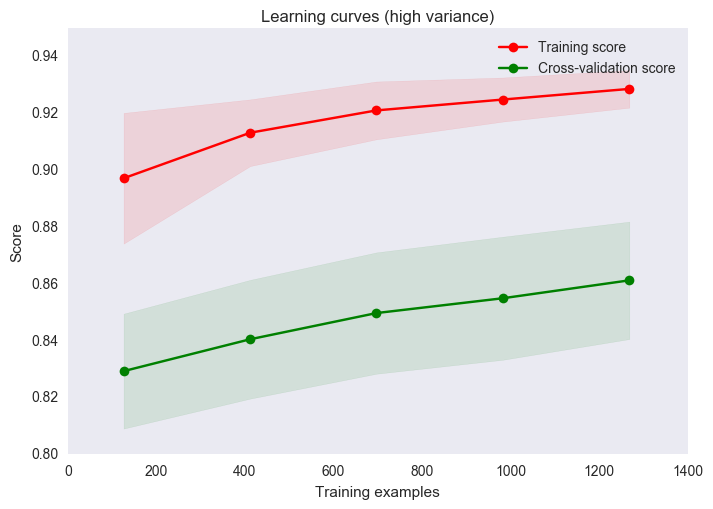

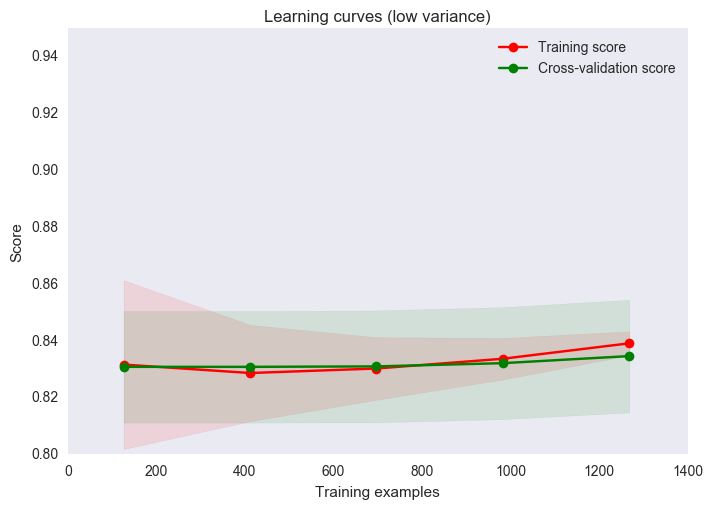

In [36]:
# UTILS: use of get_random_forests, plot_learning_curve

high_variance_rf = utils.get_random_forests(nb_trees=[10], min_leaf=[2], min_split=[2])[0]
low_variance_rf = utils.get_random_forests(nb_trees=[100], min_leaf=[10], min_split=[10])[0]

learning_curve_one = utils.plot_learning_curve(high_variance_rf, 'Learning curves (high variance)', soccer_data_all_features, all_features, classes_column, ylim=(0.8, 0.95))
learning_curve_one

learning_curve_two = utils.plot_learning_curve(low_variance_rf, 'Learning curves (low variance)', soccer_data_all_features, all_features, classes_column, ylim=(0.8, 0.95))
learning_curve_two.show()

In the first case, what we can see is that if there is not so much bias, there are still two kind of problems.

1. Firstly, even with an important training sample, we don't obtain significant improvement of global score, and even if the scores are respectable.
2. Secondly, we keep having a very high variance ; as we showed previously, overfitting is real here with our classifier.

Now, in the second case, we clearly see that the variance is highly reduced (from the previous case). At the same time, the score is not modified, which is good.


Now let's display how the <a href="https://en.wikipedia.org/wiki/Root-mean-square_deviation">Root-mean-square deviation</a> evolves with the size of the dataset.

We used the cross_val_score method and the slip/train/test process for the comparison.

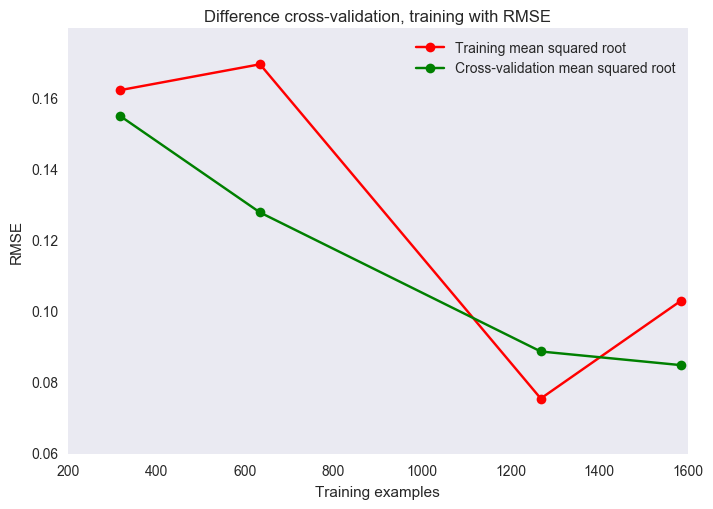

In [37]:
# UTILS: use of get_random_forests, learning_curve_mean_squared_error

# n_est = 10
cfs = utils.get_random_forests()
plt = utils.learning_curve_mean_squared_error(cfs[0], soccer_data_all_features, all_features, classes_column, 5, 50, ylim=(0.8, 0.95))
plt.show()

Here, we can see that with small data set, variance is quite high (our Random Forest classifier is subject to overfitting). However, when size of dataset is increasing, overfitting is reduced (note that variance seems to increase again when samples' number is over 1500).

> Each subset is taken randomly in the entire DataFrame each time ; the result may differ between two executions.

> From the documentation of <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score">cross_val_score</a>, we took the average of the array of RMSE returned by the cross validation.

## 4 - Question 2 : clustering the soccer players

**Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.**

In this part, we consider unsupervised classifier. More precisely, we want to cluster the soccer players in two different groups.

Let's encode the classes again, for further comparisons.

In [38]:
y = preprocessing.LabelEncoder().fit_transform(soccer_data_all_features[classes_column])

Now, as our unsupervised classifier uses distance measures, it is sensitive to the different scales of features. Thus, we decide to use a standardized scale (0-100) for all features of our DataFrame.

In [39]:
min_max_scaler = preprocessing.MinMaxScaler((0, 100))
columns = [col for col in soccer_data_all_features.columns if col not in ['rater', 'raterBinarized']]
soccer_data_all_features[columns] = min_max_scaler.fit_transform(soccer_data_all_features[columns].as_matrix())

What we want to do is to use a complete se of features and then, remove it one by one and see what is going on.

Here, we decide to sort features by importance (importance being defined in previous part) as, in fact, the order of features is quite the one we think about spontaneously, for good reasons. This will be useful when we will remove feature, only the lowest important will be removed at each iteration.

*Note: We could have done this part by permuting all the subsets, but with 124 features, the number of ensembles is 1,063382397×10^34 (2^123). There's no point in arguing that it is just infeasible in practice...*

We made the choice to remove the 'rater' (skin color) of the features set because we think that here the goal is to check if we can find two clusters representing the color skin without this feature and find something similar of the question 1 with selected features.

In [40]:
all_features_importance = utils.retrieve_above_threshold(results_single[0]['classifier'], all_features, -1).sort_values(ascending=True)

We also define a function which computes the separation of players according to their skin color. Indeed, we want to determine if the percentage of players with same skin color but who are in different groups (clusters) is high or not, to find if skin color plays an important role when clustering players in two groups or not.

We use K-Means++ here as, among other things, we already know the number of clusters we want (K=2).

In [41]:
# UTILS: use compute_skin_separation_percentage

results_kmeans = []

progress_bar = FloatProgress(min=0, max=len(all_features_importance))
display(progress_bar)

for i in range(0, len(all_features_importance)):
    
    X = soccer_data_all_features[all_features_importance.index[i:]]
    estimator = KMeans(init='k-means++', n_clusters=2, n_init=10).fit(X)
    sil_score = silhouette_score(X, estimator.labels_)
    skin_separation = utils.compute_skin_separation_percentage(estimator.labels_, y)
    
    results_kmeans.append({
            'features': set(all_features_importance.index[i:]),
            'nb_features': len(all_features_importance.index[i:]),
            'silhouette_score': sil_score,
            'estimator': estimator,
            'skin_separation': skin_separation
        })

    progress_bar.value += 1

We store all the results in a DataFrame, which is melted to have one row for each score (silhouette_score and skin_separation), and this for each estimator.

In [42]:
results_kmeans_df = pd.DataFrame.from_records(results_kmeans)
results_kmeans_df.head()

,estimator,features,nb_features,silhouette_score,skin_separation
0,"KMeans(algorithm='auto', copy_x=True, init='k-...","{Crewe Alexandra, Right Winger, Olympique Mars...",124,0.104120,0.17224
1,"KMeans(algorithm='auto', copy_x=True, init='k-...","{Crewe Alexandra, Right Winger, Olympique Mars...",123,0.104169,0.17224
2,"KMeans(algorithm='auto', copy_x=True, init='k-...","{Crewe Alexandra, Right Winger, Olympique Mars...",122,0.104217,0.17224
3,"KMeans(algorithm='auto', copy_x=True, init='k-...","{Right Winger, Olympique Marseille, Valencia C...",121,0.104263,0.17224
4,"KMeans(algorithm='auto', copy_x=True, init='k-...","{Right Winger, Olympique Marseille, Valencia C...",120,0.104491,0.17224


In [43]:
results_kmeans_df_melt = pd.melt(results_kmeans_df.iloc[:,2:], id_vars=['nb_features'], var_name='measure', value_name='score')

Let's plot the two scores for each estimators (i.e. each run of K-Means++ with decreased number of features).

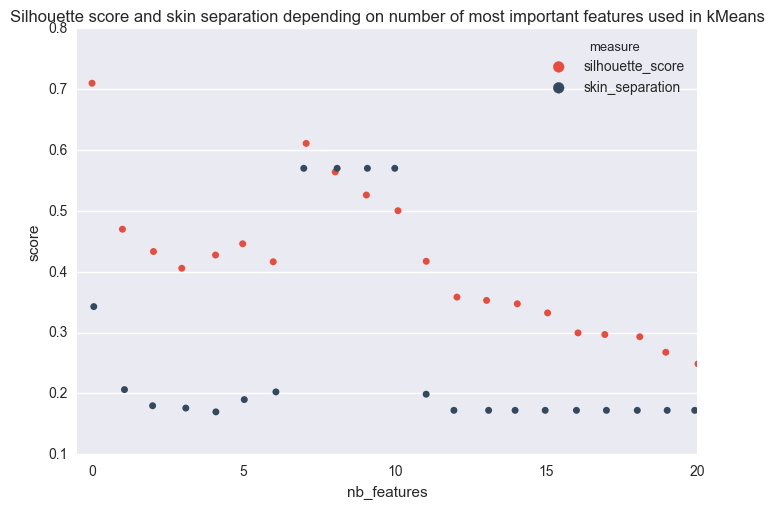

In [44]:
# Definition of data to use
ax = sns.stripplot(x="nb_features", y="score", hue="measure", data=results_kmeans_df_melt, jitter=True, palette=sns.color_palette(["#e74c3c", "#34495e"]))

# We adapt abscissa scale
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

# We only display the first configurations and adapt the ordinate axis
plt.xlim([-0.5, 20])
plt.ylim([0.1, 0.8])

# Add of title and display of plot
plt.title('Silhouette score and skin separation depending on number of most important features used in kMeans')
plt.show()

Notice that the higher silouhette score is, the better the clustering process was done.

Here, we can remark two important things.

First, we see that around 10 features, we get the most interesting results.

Then, we see that even if the score is quite good (but not "wow!" for all that), the skin separation is not very high (below 50%).

From the second observation, we can then conclude that skin color is not really an important feature when considering grouping the players in two different clusters. It seems, in contrary, that it is the performance of players that is used to cluster them (indeed, we recall that the two most important features are the number of red cards a player receives and the number of goals, but these features are also the one that provide the highest silhouette score in the same time, as it is shown by the previous graph).

***

The following cells allow the reader to execute K-Means++ using all the possible subsets of the selected features (and not all of them). We will see if we have a different result from above.

**Important note:** We draw reader's attention on the fact that these computations take a lot of time to execute, and need high resources.

In [45]:
# This returns all subsets of values grouped by a number
def findsubsets(values, groupby):
    return set(itertools.combinations(values, groupby))

# We keep only the 10 more important features 
selected_important_features = all_features_importance.index[-10:]

# We get all subsets
all_subsets_features = set()
for i in range(1, len(selected_important_features)):
    all_subsets_features |= findsubsets(selected_important_features, i)

In [46]:
results_selected_features = []

total_iteration = len(all_subsets_features)
progress_bar = FloatProgress(min=0, max=total_iteration)
display(progress_bar)

print('Number of total iteration to do (very long): ' + str(total_iteration))

for features in all_subsets_features:

    X = soccer_data_all_features[list(features)]
    estimator = KMeans(init='k-means++', n_clusters=2, n_init=10).fit(X)
    sil_score = silhouette_score(X, estimator.labels_)
    skin_separation = utils.compute_skin_separation_percentage(estimator.labels_, y)
    
    results_selected_features.append({
            'features': features,
            'nb_features': len(features),
            'silhouette_score': sil_score,
            'estimator': estimator,
            'skin_separation': skin_separation
        })

    progress_bar.value += 1

Number of total iteration to do (very long): 1022


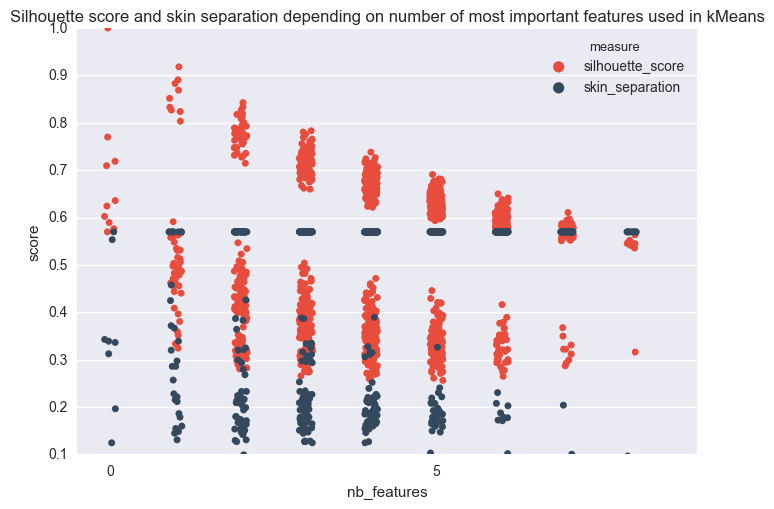

In [47]:
results_selected_features_df = pd.DataFrame.from_records(results_selected_features)
results_selected_features_df_melt = pd.melt(results_selected_features_df.iloc[:,2:], id_vars=['nb_features'], var_name='measure', value_name='score')

# Definition of data to use
ax = sns.stripplot(x="nb_features", y="score", hue="measure", data=results_selected_features_df_melt, jitter=True, palette=sns.color_palette(["#e74c3c", "#34495e"]))

# We adapt abscissa scale
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

#We only display the first configurations and adapt the ordinate axis
plt.xlim([-0.5, 9])
plt.ylim([0.1, 1])

# Add of title and display of plot
plt.title('Silhouette score and skin separation depending on number of most important features used in kMeans')
plt.show()

Like we see, we can make the same conclusion than before. We haven't a clean separation regarding the color skin. But with some subsets we have a better silhouette score. We can also see that the more features there are, the lower the score is. So, it is not necessary/useful to try with all features (this will take a lot of hours and most likely the result will remain the same).